In [3]:
import pickle
from scipy import sparse
from sklearn.linear_model import Ridge, LogisticRegression
import statistics
from tqdm import tqdm
import scipy.stats as sts

from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import itertools
import math
# from google.colab import drive


In [4]:
# drive.mount('/content/drive')
# 

In [5]:
# !unzip ./chgk.zip

Archive:  ./chgk.zip
replace players.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
with open('results.pkl', 'rb') as file:
    results_pkl = pickle.load(file)
with open('./players.pkl', 'rb') as file:
    players_pkl = pickle.load(file)
with open('./tournaments.pkl', 'rb') as file:
    tournaments_pkl = pickle.load(file)

In [7]:
players = pd.DataFrame(players_pkl).transpose()
players["id"] = players["id"].astype(int)

players.fillna("",inplace=True)
players.head()

,id,name,patronymic,surname
1,1,Алексей,,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


In [8]:
tournaments = pd.DataFrame(tournaments_pkl).transpose()
tournaments["id"] = tournaments["id"].astype(int)

tournaments["dateStart"] = pd.to_datetime(tournaments["dateStart"].str[:18], infer_datetime_format=True)
tournaments["dateEnd"] = pd.to_datetime(tournaments["dateEnd"].str[:18], infer_datetime_format=True)
drop_columns =["name", "dateStart", "dateEnd", "type", "season", "orgcommittee", "synchData", "questionQty"]

tournaments_train = tournaments[tournaments["dateStart"].dt.year == 2019].reset_index(drop=True)
tournaments_train.drop(columns=drop_columns, inplace=True)

tournaments_test = tournaments[tournaments["dateStart"].dt.year == 2020].reset_index(drop=True)
tournaments_test.drop(columns=drop_columns, inplace=True)
tournaments_train.head()

,id
0,4772
1,4973
2,4974
3,4975
4,4986


In [9]:
mask_dict = {}
for key, value in results_pkl.items():
    if not value or 'mask' not in value[0] or value[0]['mask'] is None:
        continue
    mask_dict[key] = value 

game_dict = {}
for game_id, game_stats in mask_dict.items():
    full_data = {}
    team_list, pos_list, res_list, players_list = [], [], [], []
    for data in game_stats:
        team_list.append(data['team']['id'])
        pos_list.append(data['position'] if 'position' in data else None)
        res_list.append(data['mask'])

        data_players = []
        for player in data['teamMembers']:
            data_players.append(player['player']['id'])
        players_list.append(data_players)

    game_dict[game_id] = {'team_id': team_list, 'position': pos_list, 
                          'result': res_list,  'players': players_list}
    
df_games = pd.DataFrame(game_dict).transpose()
df_games["id"] = df_games.index
df_games.head()

,team_id,position,result,players,id
22,"[1, 2, 670, 173, 175, 188, 240, 176, 5, 7, 3, ...","[1, 2.5, 2.5, 4.5, 4.5, 6.5, 6.5, 8, 9, 10, 11...",[011101110110111000110111001111111111001111110...,"[[1560, 2935, 3270, 4878, 18935, 32979, 36497]...",22
76,"[5, 188, 1, 2, 7, 175, 3, 168, 313, 1902, 173,...","[1, 2, 3, 4, 5, 6, 8.5, 8.5, 8.5, 8.5, 11, 12....",[001111101111111001011101111011100001110010111...,"[[1603, 5935, 17050, 18036, 18332, 30990], [32...",76
141,"[1, 188, 670, 2, 168, 5335, 5, 313, 414, 700, ...","[1, 2.5, 2.5, 4, 5, 6, 9, 9, 9, 9, 9, 12.5, 12...",[110110111101111111011110011110111111100111111...,"[[2935, 3270, 18935, 20612, 29800, 32979], [32...",141
226,"[5, 1, 168, 188, 670, 2, 175, 414, 214, 967, 2...","[1, 2.5, 2.5, 4.5, 4.5, 6.5, 6.5, 8, 10, 10, 1...",[101011110010010101111010111110110011011111111...,"[[5935, 17050, 18036, 18332, 30990, 35065], [2...",226
315,"[2, 188, 5, 670, 26, 173, 6000, 1, 168, 407, 1...","[1, 2, 3.5, 3.5, 6, 6, 6, 8.5, 8.5, 10.5, 10.5...",[011111000111101111110111111110111101001011111...,"[[27403, 25882, 30475, 34846, 13551, 707, 2180...",315


In [10]:
games_train = tournaments_train.merge(df_games, on='id').explode(["team_id", "position", "result", "players"]).explode('players')
games_test = tournaments_test.merge(df_games, on='id').explode(["team_id", "position", "result", "players"]).explode('players')

In [11]:
def preprocessing(data):
    def unpack_result(gameid_col, result_col):
        result_vector = [int(d) if d.isnumeric() else 0 for d in result_col]
        answer_vector = [f'{gameid_col}_{i}' for i in range(len(result_col))]
        return answer_vector, result_vector


    data.dropna(inplace=True)
    data[[f'{"id"}_num', "is_answered"]] = data.apply(lambda row: unpack_result(row["id"], row["result"]), axis=1, result_type='expand')
    data.drop(columns=['result'], inplace=True)
    data = data.explode([f'{"id"}_num', "is_answered"])
    data = data.astype(dtype={"team_id": np.int32, "players": np.int32, "id": np.int32, "is_answered": np.int32, "position": np.float32})

    return data

In [12]:
games_train = tournaments_train.merge(df_games, on='id').explode(["team_id", "position", "result", "players"]).explode('players')
data_train = preprocessing(games_train)


games_test = tournaments_test.merge(df_games, on='id').explode(["team_id", "position", "result", "players"]).explode('players')
data_test = preprocessing(games_test)

In [13]:
data_train

,id,team_id,position,players,id_num,is_answered
0,4772,45556,1.0,6212,4772_0,1
0,4772,45556,1.0,6212,4772_1,1
0,4772,45556,1.0,6212,4772_2,1
0,4772,45556,1.0,6212,4772_3,1
0,4772,45556,1.0,6212,4772_4,1
...,...,...,...,...,...,...
673,6255,76130,2019.0,217156,6255_31,0
673,6255,76130,2019.0,217156,6255_32,0
673,6255,76130,2019.0,217156,6255_33,0
673,6255,76130,2019.0,217156,6255_34,0


In [14]:
from sklearn.base import BaseEstimator
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats.mstats import spearmanr, kendalltau

import torch.nn as nn
import torch
import torch.nn.functional as F


In [15]:
data_train.head()

,id,team_id,position,players,id_num,is_answered
0,4772,45556,1.0,6212,4772_0,1
0,4772,45556,1.0,6212,4772_1,1
0,4772,45556,1.0,6212,4772_2,1
0,4772,45556,1.0,6212,4772_3,1
0,4772,45556,1.0,6212,4772_4,1


In [16]:
y_train = data_train["is_answered"].copy()
enc = OneHotEncoder()
X_train = enc.fit_transform(data_train[["players", "id_num"]])

In [36]:
enc.get_feature_names_out()

array(['players_15', 'players_16', 'players_23', ..., 'id_num_6255_97',
       'id_num_6255_98', 'id_num_6255_99'], dtype=object)

In [20]:
#Basic log reg
class LogReg(nn.Module):
    def __init__(self, in_features, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x):
        return F.sigmoid(self.linear(x))

In [21]:
X_train = X_train.tocoo()
x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((X_train.row, X_train.col))),
    torch.FloatTensor(X_train.data)
)

y = torch.FloatTensor(data_train["is_answered"].values).view(-1, 1)


In [22]:
def train(model, criterion, optimizer, num_epochs=100):
    loss_val = None
    pbar = tqdm(range(num_epochs))
    loses = []
    for i in pbar:
        optimizer.zero_grad()
        out = model(x)

        loss = criterion(out, y)
        loss.backward()

        optimizer.step()
        loss_val = loss.detach().item()
        losses.append(loss_val)
        pbar.set_postfix({'loss_val': loss_val})

    return losses

In [23]:
model = LogReg(x.shape[1])


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
losses = []



100%|█████████████████████████| 100/100 [03:03<00:00,  1.84s/it, loss_val=0.481]


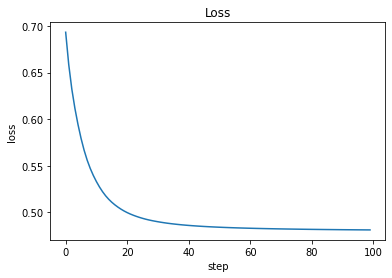

In [27]:
model = LogReg(x.shape[1])

fig, ax = plt.subplots()
loss_list = train(model, criterion, optimizer, num_epochs=100)

ax.plot(loss_list)
ax.set_xlabel('step')
ax.set_ylabel('loss val')
ax.set_title('Model loss')

# impact


### Бейзлайн, который требуется побить

In [35]:
impact = {}
model.load_state_dict(torch.load("log_reg.pth"))

wt = model.linear.weight.data[0].numpy()
features = enc.get_feature_names_out()

for idx, player_id in enumerate(features):
    if player_id.startswith('players'):
        player_id = int(player_id[8:])
        impact[player_id] = wt[idx]
        
data = [(player_id, imp) for player_id, imp in impact.items()]
data = sorted(data,  reverse=True, key=lambda x: x[1])[:20]

top_dict = defaultdict(list)

for pos, (player_id, imp) in enumerate(top, 1):
    name = players.loc[player_id]["name"]
    surname = players.loc[player_id]["surname"]
    print(f'Player - {name} {surname}, pos - {pos}, impact - {imp}')

Player - Павел Щербина, pos - 1, impact - 4.076584339141846
Player - Максим Руссо, pos - 2, impact - 3.3905844688415527
Player - Александра Брутер, pos - 3, impact - 3.266859292984009
Player - Иван Семушин, pos - 4, impact - 3.2387802600860596
Player - Дмитрий Кудинов, pos - 5, impact - 3.150224208831787
Player - Максим Пилипенко, pos - 6, impact - 3.083094358444214
Player - Артём Сорожкин, pos - 7, impact - 3.0772697925567627
Player - Сергей Спешков, pos - 8, impact - 3.072958469390869
Player - Михаил Савченков, pos - 9, impact - 3.071894645690918
Player - Валентина Подюкова, pos - 10, impact - 2.9726409912109375
Player - Станислав Мереминский, pos - 11, impact - 2.950007438659668
Player - Михаил Левандовский, pos - 12, impact - 2.9479684829711914
Player - Ирина Прокофьева, pos - 13, impact - 2.9065301418304443
Player - Сергей Николенко, pos - 14, impact - 2.878936529159546
Player - Антон Саксонов, pos - 15, impact - 2.8722150325775146
Player - Илья Новиков, pos - 16, impact - 2.85818

# Рейтинг
Идея в том, что мы рассматриваем вероятность ответа каждого участника независимо
$$ Team = \prod_{i=1}^N (1 - sigmoid(Qs + Sk  + b)$$
Qs - Относительная сложнотсь вопроса

Sk - Индивидуальные умения грока

b - bias вычислений

In [58]:
class TeamRanking:
    def __init__(self, model, ohe):
        self.impact = {}
        self.diff_dict = defaultdict(list)

        wt = model.linear.weight.data[0].numpy()
        features = ohe.get_feature_names_out()

        for idx, player_id in enumerate(feature_names):
            player_impact = wt[idx]
            if player_id.startswith('players'):
                player_id = int(player_id[8:])
                self.impact[player_id] = player_impact
            else:
                col_id = player_id.split("_")[2]
                self.diff_dict[col_id].append(player_impact)
        
        self.tourn_mean = {t_id: np.mean(q) for t_id, q in self.diff_dict.items()}
        self.empty_vals = sum(self.tourn_mean.values()) / len(self.tourn_mean)
        self.empty_pl = sum(self.impact.values()) / len(self.impact)
#         np.array(list(self.impact.values())).mean()
#         sum(self.tourn_q_mean.values()) / len(self.tourn_q_mean)
        self.bias = model.linear.bias.data[0].numpy()
    

    def predict(self, data):
        
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        
        data = data.copy()
        gr_truth = data.groupby(["id", "players"])["position"].first()        

            
        data["tourn"] = data["id"].map(self.tourn_mean).fillna(self.empty_vals)
        data["impact"] = data["players"].map(self.impact).fillna(self.empty_pl)
        data["probs"] = data.apply(lambda row: sigmoid(row["tourn"] + row["impact"] + self.bias), axis=1)
        
        ranj = data.groupby(["id", "players"])["probs"].apply(lambda x: np.prod(1 - x))
        
        result = pd.concat([ranj, gr_truth], axis=1)
        result.sort_values(["id", "probs"], ascending=[True, True], inplace=True)
        
        return result

    def eval(self, result):
        def get_spearman(x, y):
            try:
                return spearmanr(x, y).correlation
            except:
                return 1
            
        kendall = result.groupby("id").apply(lambda x: kendalltau(x["position"], x["probs"]).correlation).mean()
        spearman = result.groupby("id").apply(lambda x: get_spearman(x["position"], x["probs"])).mean()
        
        return spearman, kendall

In [59]:
ranking_model = TeamRanking(model, enc)
res = ranking_model.predict(data_test)
spearman, kendall = ranking_model.eval(res)
print(f'Spearman rho test: {spearman}')
print(f'Kendall rho test: {kendall}')

/home/v_shaposhnikov/env/lib/python3.9/site-packages/scipy/stats/mstats_basic.py:652: RuntimeWarning: invalid value encountered in double_scalars
  tau = (C-D) / denom
/home/v_shaposhnikov/env/lib/python3.9/site-packages/scipy/stats/mstats_basic.py:687: RuntimeWarning: invalid value encountered in double_scalars
  z = (C-D)/np.sqrt(var_s)


Spearman rho test: 0.7273395859526212
Kendall rho test: 0.5695531946556612


  0%|                                                     | 0/5 [00:00<?, ?it/s]

1
2
3


  0%|                                                     | 0/5 [00:46<?, ?it/s]


KeyboardInterrupt: 

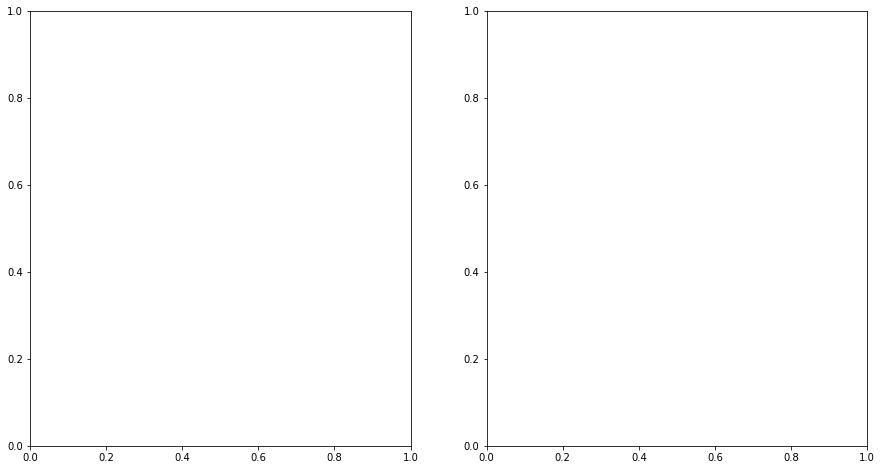

In [69]:
def train(model, criterion, optimizer, num_epochs=100):
    loss_val = None
    pbar = tqdm(range(num_epochs))
    loses = []
    for i in pbar:
        optimizer.zero_grad()
        out = model(x)

        loss = criterion(out, y)
        loss.backward()

        optimizer.step()
        loss_val = loss.detach().item()
        losses.append(loss_val)
        pbar.set_postfix({'loss_val': loss_val})

    return losses
        
    
def data_preporation(data, new_predictions):
    print(1)
    data["y_pred"] = new_predictions
    print(2)
    data.loc[data["is_answered"] == 0, "y_pred"] = 0
    print(3)
    den = data.loc[data["is_answered"] == 1].groupby(["players", "id_num"])["y_pred"].transform(lambda x: 1 - np.prod(1 - x.values))
    print(4)
    data.loc[data["is_answered"] == 1, "y_pred"] = data.loc[data["is_answered"] == 1, "y_pred"] / den
    return data


data = data_train.copy()
GL_STEPS = 5
model_losses, spearmans, kendalls = [], [], []

model.eval()
predictions = model(x).detach().numpy().ravel()
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

for i in tqdm(range(GL_STEPS)):
    model.train()
    
    data = data_preporation(data, predictions)
    print('Prep stage finished')
    y = torch.FloatTensor(data['y_pred'].values).view(-1, 1)
    
    losses = train(model, criterion, optimizer)
    mean_loss = sum(losses) / len(losses)
    model_losses.append(mean_loss)
        
    model.eval()
    predictions = model(x).detach().numpy().ravel()
    
    
    ranking_model = TeamRanking(model, ohe)
    res = ranking_model.predict(data_test)
    spearman, kendall = ranking_model.eval(res)

    spearmans.append(spearman)
    kendalls.append(kendall)


Данная сдача не является финальной, я думал дедлайн в вс и не успел досчитать до конца(